In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pymc as pm
import pymc_experimental as pmx
import pytensor.tensor as pt
import arviz as az

# Data Generation

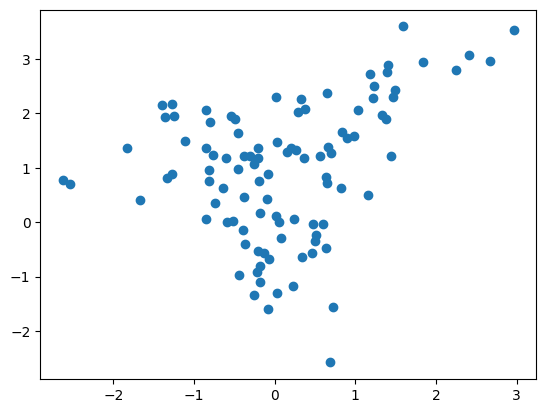

In [20]:
N_sample = 100
confounder = np.random.randn(N_sample) 
treatment = np.random.randn(N_sample) + 1.5 * np.abs(confounder) - 0.5 * confounder
mediator = np.random.randn(N_sample) - 0.5 * treatment**2
outcome = .3*np.random.randn(N_sample) + 1 * treatment + 0.5 * confounder + 0.2 * mediator + 0.1
data = pd.DataFrame({'confounder': confounder, 'treatment': treatment, 'outcome': outcome, 'confounder_sq': confounder**2, 'mediator': mediator, 'treatment_sq': treatment**2})
plt.plot(confounder, outcome, 'o')

In [21]:
primary_model = sm.OLS(data['outcome'], sm.add_constant(data[['treatment', 'confounder', 'mediator']])).fit()
primary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     489.7
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           4.94e-58
Time:                        17:09:04   Log-Likelihood:                -24.900
No. Observations:                 100   AIC:                             57.80
Df Residuals:                      96   BIC:                             68.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.042      1.829      0.070      -0.006       0.159
treatment      1.0489      0.031     33.493      0.000       0.987       1.111
confounder     0.5145      0.034     15.186      0.000       0.447       0.582
mediator       0.2195      0.017     13.296      0.000       0.187       0.252
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.700
Skew:                          -0.128   Prob(JB):                        0.705
Kurtosis:                       2.680   Cond. No.                         5.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
mediator_model = sm.OLS(data['mediator'], (data[['treatment_sq']])).fit()
mediator_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               mediator   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              1053.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):                    1.48e-54
Time:                        17:09:07   Log-Likelihood:                         -137.56
No. Observations:                 100   AIC:                                      277.1
Df Residuals:                      99   BIC:                                      279.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
treatment_sq    -0.5278      0.016    -32.445      0.000      -0.560      -0.495
==============================================================================
Omnibus:                        0.871   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.647   Jarque-Bera (JB):                0.408
Skew:                           0.029   Prob(JB):                        0.816
Kurtosis:                       3.307   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
np.sqrt(primary_model.scale)

0.31678716813105917

In [24]:
def mediator_f(treatment):
  return mediator_model.params['treatment_sq'] * treatment**2 + np.random.randn(len(treatment))

def confounder_f(len):
  return np.random.randn(len)

def outcome_f(treatment):
  return primary_model.params['treatment'] * treatment + primary_model.params['confounder'] * confounder_f(len(treatment)) + primary_model.params['mediator'] * mediator_f(treatment) + primary_model.params['const'] + np.sqrt(primary_model.scale)*np.random.randn(len(treatment)) 

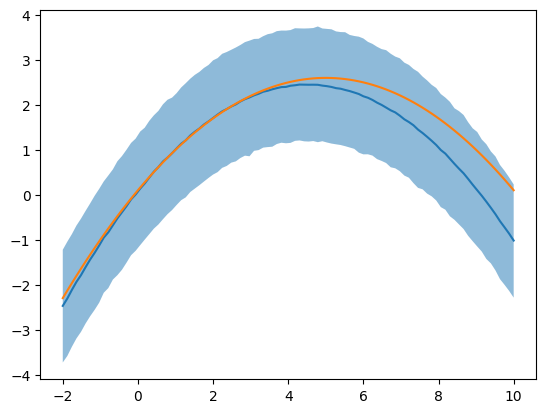

In [25]:
test_treatment = np.linspace(-2, 10, 100)
samples = np.stack([outcome_f(test_treatment) for _ in range(10_000)])
plt.plot(test_treatment, samples.mean(axis=0))
plt.fill_between(test_treatment, np.percentile(samples, 2.5, axis=0), np.percentile(samples, 97.5, axis=0), alpha=0.5)
plt.plot(test_treatment, -0.2*0.5*test_treatment**2+1*test_treatment+.1)